In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import glob
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing import image_dataset_from_directory
import PIL
from PIL import Image
import zipfile
import matplotlib.pyplot as plt

# Ensure TensorFlow sees a GPU if available
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
print("TensorFlow version:", tf.__version__)


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

TensorFlow version: 2.18.0


# Notebook Overview

In this notebook, we will build a Deep Convolutional GAN (DCGAN) trained on Monet paintings. The goal is to generate 7,000–10,000 Monet‐style images of size 256×256×3. We will use ReLU activations in the generator and the standard binary crossentropy GAN loss.

The workflow is as follows:

    Imports & Setup

    Hyperparameters & Paths

    Exploratory Data Analysis (EDA)

        Count of Monet images

        Image shapes & pixel distributions

        Visualizing random samples

    Dataset Preparation (Monet images)

    DCGAN Architecture

        Generator (ReLU activations)

        Discriminator

        Loss functions & optimizers

    Training Loop

    Generating & Saving 7,000 Monet‐Style Images

    Zipping the Generated Images

    (Optional) Display a Few Generated Samples

Throughout the notebook, each section will begin with a Markdown description explaining its purpose. EDA code blocks will be followed by narrative descriptions of what the output would look like.

# Hyperparameters & Paths

In this section, we define file paths and hyperparameters. Adjust MONET_DIR if your Kaggle dataset directory differs. We also create an output directory for generated images.

In [11]:
MONET_DIR = "/kaggle/input/gan-getting-started/monet_jpg"                    # Directory containing Monet .jpg images, each 256×256
OUTPUT_DIR = "/kaggle/working/generated_images"     # Temporary directory for generated images
ZIP_PATH = "/kaggle/working/images.zip"             # Final zip file path

# Hyperparameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
CHANNELS = 3
BATCH_SIZE = 16
BUFFER_SIZE = 1000

NOISE_DIM = 100
NUM_EPOCHS = 200
LEARNING_RATE = 2e-4
BETA_1 = 0.5   # As recommended for DCGAN stability
NUM_EXAMPLES_TO_GENERATE = 7000  # Number of Monet‐style images to generate

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Paths and hyperparameters set.")

Paths and hyperparameters set.


# Exploratory Data Analysis (EDA)

Before training, it is useful to inspect the Monet dataset:

    Count the total number of images.

    Check image shapes and confirm they are 256×256.

    Visualize a few random Monet images.

    Plot pixel intensity distributions (histogram of a small sample) to see color ranges.

4.1 Count Total Monet Images



In [16]:
# List all .jpg files in MONET_DIR
monet_files = glob.glob(os.path.join(MONET_DIR, "*.jpg"))
total_monet = len(monet_files)
print(f"Total Monet images found: {total_monet}")

Total Monet images found: 300


# Check Image Shapes

We will load a few images and inspect their dimensions to verify they are 256×256×3. If any images differ, we will still resize later, but it’s good to confirm.

In [17]:
# Sample 5 random files and print their shapes
sample_files = random.sample(monet_files, min(5, total_monet))

for file_path in sample_files:
    img = Image.open(file_path)
    width, height = img.size
    mode = img.mode
    print(f"{os.path.basename(file_path)}: size = ({width}, {height}), mode = {mode}")

6742294320.jpg: size = (256, 256), mode = RGB
82b9fd68b1.jpg: size = (256, 256), mode = RGB
7017e6caa1.jpg: size = (256, 256), mode = RGB
fb3b06dcb2.jpg: size = (256, 256), mode = RGB
66226e18fc.jpg: size = (256, 256), mode = RGB


# Visualize Random Monet Samples

Below, we display a 3×3 grid of randomly chosen Monet images. This helps us visually inspect style, brushstroke patterns, and color palettes present in the dataset.

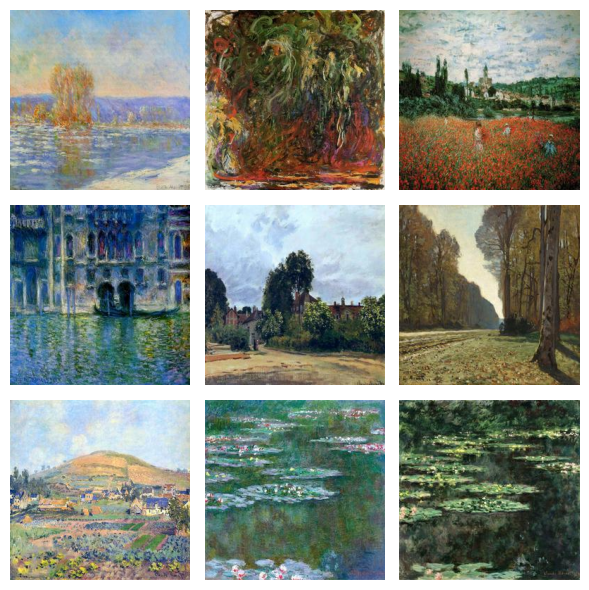

In [19]:
def show_random_monet_images(image_paths, num_images=9):
    plt.figure(figsize=(6, 6))
    selected = random.sample(image_paths, num_images)
    for i, path in enumerate(selected):
        img = Image.open(path)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_random_monet_images(monet_files, num_images=9)

# Pixel Intensity Distribution (Histogram)

To understand pixel value distributions, we will sample 100 images, flatten their pixel values, and plot a histogram for each R, G, B channel.

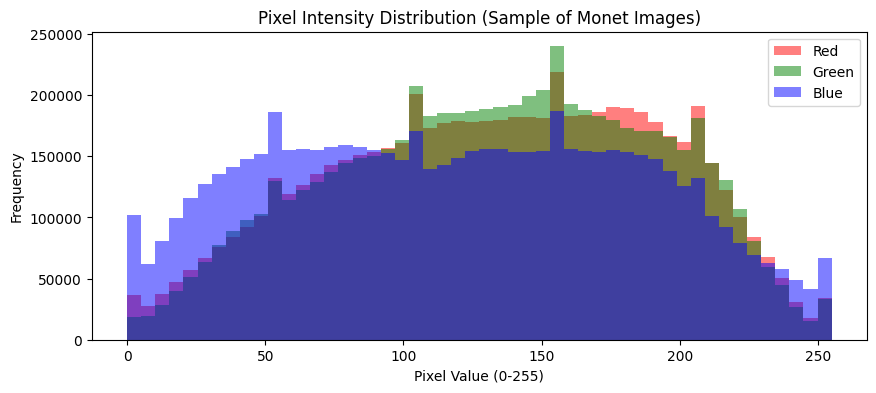

In [20]:
# Sample 100 images (or fewer if dataset < 100)
sample_for_hist = random.sample(monet_files, min(100, total_monet))

# Accumulate pixel values from the sample
r_vals, g_vals, b_vals = [], [], []
for fp in sample_for_hist:
    img = Image.open(fp).convert("RGB")
    arr = np.array(img)
    r_vals.extend(arr[:, :, 0].flatten())
    g_vals.extend(arr[:, :, 1].flatten())
    b_vals.extend(arr[:, :, 2].flatten())

# Plot histograms for R, G, B channels
plt.figure(figsize=(10, 4))
plt.hist(r_vals, bins=50, alpha=0.5, label="Red", color="red")
plt.hist(g_vals, bins=50, alpha=0.5, label="Green", color="green")
plt.hist(b_vals, bins=50, alpha=0.5, label="Blue", color="blue")
plt.title("Pixel Intensity Distribution (Sample of Monet Images)")
plt.xlabel("Pixel Value (0-255)")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.show()

# Dataset Preparation (Monet Images)

Now that we have inspected the dataset, we build a tf.data.Dataset pipeline. Each image will be:

    Loaded from disk

    Decoded as JPEG

    Resized to 256×256 (if not already)

    Scaled from [0,1] → [−1,1] (for tanh output training)

    Shuffled and batched

In [21]:
def preprocess_image(file_path):
    """
    Load an image from `file_path`, decode JPEG, 
    convert to float32 [0,1], resize to 256×256, 
    and scale to [-1,1].
    """
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)              # [0,255]
    img = tf.image.convert_image_dtype(img, tf.float32)      # [0,1]
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])      # ensure shape
    img = (img * 2.0) - 1.0                                  # [−1,1]
    return img

# Build tf.data.Dataset
monet_ds = tf.data.Dataset.from_tensor_slices(monet_files)
monet_ds = (
    monet_ds
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

print("Dataset pipeline ready. First batch shape:", next(iter(monet_ds)).shape)

Dataset pipeline ready. First batch shape: (16, 256, 256, 3)


# DCGAN Architecture

We now define the Generator and Discriminator networks. The Generator upsamples a 100D noise vector into a 256×256×3 image using Conv2DTranspose layers with ReLU activations (and tanh at the output). The Discriminator downsamples a 256×256×3 image into a single logit using Conv2D, LeakyReLU, and Dropout.
6.1 Generator (with ReLU Activations)

The generator:

    Projects the noise vector to 16×16×512 via a Dense layer, followed by BatchNorm + ReLU.

    Four Conv2DTranspose layers gradually upsample to 32×32×256 → 64×64×128 → 128×128×64 → 256×256×3.

    Hidden layers use ReLU; output layer uses tanh to produce pixel values in [−1,1].

In [22]:
def build_generator():
    model = Sequential(name="Generator")
    
    # 1) Dense layer to project noise → 16×16×512
    model.add(layers.Dense(16 * 16 * 512, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((16, 16, 512)))  # Now shape: (16,16,512)

    # 2) Upsample to 32×32×256
    model.add(layers.Conv2DTranspose(
        256, kernel_size=5, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # 3) Upsample to 64×64×128
    model.add(layers.Conv2DTranspose(
        128, kernel_size=5, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # 4) Upsample to 128×128×64
    model.add(layers.Conv2DTranspose(
        64, kernel_size=5, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # 5) Upsample to 256×256×3 (output)
    model.add(layers.Conv2DTranspose(
        CHANNELS, kernel_size=5, strides=2, padding="same", use_bias=False, activation="tanh"
    ))

    return model

generator = build_generator()
generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 131072)              │      13,107,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 131072)              │         524,288 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 256)         │       3,276,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 128)         │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 128, 128, 64)        │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 256, 256, 3)         │           4,800 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,938,880 (68.43 MB)

 Trainable params: 17,675,840 (67.43 MB)

 Non-trainable params: 263,040 (1.00 MB)

# Discriminator

The discriminator:

    Takes a 256×256×3 image as input.

    Four Conv2D layers to downsample: 128×128×64 → 64×64×128 → 32×32×256 → 16×16×512.

    Each Conv2D is followed by LeakyReLU (alpha=0.2) and Dropout(0.3). BatchNorm is applied from the second block onward.

    Finally, flatten and Dense→1 logit (no activation), which we will feed into a binary crossentropy loss.

In [23]:
def build_discriminator():
    model = Sequential(name="Discriminator")
    
    # 1) Downsample to 128×128×64
    model.add(layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                            input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # 2) Downsample to 64×64×128
    model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # 3) Downsample to 32×32×256
    model.add(layers.Conv2D(256, kernel_size=5, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # 4) Downsample to 16×16×512
    model.add(layers.Conv2D(512, kernel_size=5, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # 5) Flatten & output
    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # single logit (real / fake)

    return model

discriminator = build_discriminator()
discriminator.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 512)         │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │         131,073 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,441,217 (16.94 MB)

 Trainable params: 4,439,425 (16.94 MB)

 Non-trainable params: 1,792 (7.00 KB)

# Loss Functions & Optimizers

We use BinaryCrossentropy (from logits) as the loss. The discriminator’s loss is the sum of real‐image loss and fake‐image loss. The generator’s loss tries to fool the discriminator into classifying fake images as real.

In [24]:
# Define Binary Crossentropy loss (from_logits=True, since discriminator’s output is a raw logit)
cross_entropy = BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_logits, fake_logits):
    """
    Calculates discriminator loss:
    - real_logits should be classified as 1 (real)
    - fake_logits should be classified as 0 (fake)
    """
    real_loss = cross_entropy(tf.ones_like(real_logits), real_logits)
    fake_loss = cross_entropy(tf.zeros_like(fake_logits), fake_logits)
    return real_loss + fake_loss

def generator_loss(fake_logits):
    """
    Generator attempts to have discriminator classify fake images as real (label=1).
    """
    return cross_entropy(tf.ones_like(fake_logits), fake_logits)

# Optimizers for both Generator and Discriminator
generator_optimizer = Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1)
discriminator_optimizer = Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1)

print("Loss functions and optimizers defined.")


Loss functions and optimizers defined.


# Training Loop

We now implement the DCGAN training loop. Each training step does the following:

    Sample a batch of real images.

    Generate a batch of fake images from random noise.

    Compute discriminator loss using real logits vs. fake logits → update discriminator.

    Compute generator loss using fresh random noise → update generator.

We wrap this in a @tf.function to compile it to a graph. After each epoch, we log average losses.

In [25]:
@tf.function
def train_step(real_images):
    """
    Performs one training step:
    - real_images: batch of real Monet images
    Returns:
      discriminator_loss, generator_loss
    """
    # 1) Generate random noise
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    # 2) Record gradients for both networks
    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        # a) Generate fake images
        generated_images = generator(noise, training=True)

        # b) Discriminator outputs on real and fake
        real_logits = discriminator(real_images, training=True)
        fake_logits = discriminator(generated_images, training=True)

        # c) Compute losses
        d_loss = discriminator_loss(real_logits, fake_logits)
        g_loss = generator_loss(fake_logits)

    # 3) Compute gradients
    gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)
    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)

    # 4) Apply gradients
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )
    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )

    return d_loss, g_loss

# Full training loop over all epochs
import time

def train(dataset, epochs):
    """
    Trains the DCGAN for a specified number of epochs.
    Logs epoch‐level average losses.
    """
    for epoch in range(1, epochs + 1):
        start = time.time()
        total_d_loss = 0.0
        total_g_loss = 0.0
        num_batches = 0

        for image_batch in dataset:
            d_loss, g_loss = train_step(image_batch)
            total_d_loss += d_loss
            total_g_loss += g_loss
            num_batches += 1

        avg_d_loss = total_d_loss / num_batches
        avg_g_loss = total_g_loss / num_batches
        print(
            f"Epoch {epoch}/{epochs}  —  "
            f"D_loss: {avg_d_loss:.4f}  |  G_loss: {avg_g_loss:.4f}  |  "
            f"time: {time.time() - start:.2f}s"
        )

# Execute training
train(monet_ds, NUM_EPOCHS)

Epoch 1/200  —  D_loss: 1.1463  |  G_loss: 2.0805  |  time: 201.92s
Epoch 2/200  —  D_loss: 1.1650  |  G_loss: 5.2082  |  time: 178.19s
Epoch 3/200  —  D_loss: 0.5209  |  G_loss: 4.6520  |  time: 178.03s
Epoch 4/200  —  D_loss: 1.0360  |  G_loss: 10.2614  |  time: 178.09s
Epoch 5/200  —  D_loss: 1.8798  |  G_loss: 4.7522  |  time: 176.76s
Epoch 6/200  —  D_loss: 1.4774  |  G_loss: 4.4017  |  time: 179.19s
Epoch 7/200  —  D_loss: 1.3313  |  G_loss: 4.3920  |  time: 194.43s
Epoch 8/200  —  D_loss: 1.2062  |  G_loss: 4.1278  |  time: 183.71s
Epoch 9/200  —  D_loss: 1.1960  |  G_loss: 6.5721  |  time: 182.03s
Epoch 10/200  —  D_loss: 1.0720  |  G_loss: 5.8752  |  time: 180.03s
Epoch 11/200  —  D_loss: 2.0312  |  G_loss: 5.1268  |  time: 179.20s
Epoch 12/200  —  D_loss: 1.2844  |  G_loss: 3.2893  |  time: 201.92s
Epoch 13/200  —  D_loss: 1.8099  |  G_loss: 3.9106  |  time: 179.42s
Epoch 14/200  —  D_loss: 1.6986  |  G_loss: 3.4371  |  time: 179.12s
Epoch 15/200  —  D_loss: 1.1599  |  G_loss

# Generating & Saving 7,000 Monet‐Style Images

After training, we use the generator to sample NUM_EXAMPLES_TO_GENERATE = 7000 noise vectors, produce images, and save each as a JPEG file in OUTPUT_DIR. We will re‐scale pixel values from [−1,1] → [0,255] using a helper function.

In [ ]:
def deprocess_image(img_tensor):
    """
    Converts image from [-1,1] float32 to uint8 [0,255].
    """
    img = (img_tensor + 1.0) * 127.5  # [0,255]
    img = tf.cast(img, tf.uint8)
    return img

def generate_and_save_images(generator, num_images, output_dir, noise_dim):
    """
    Generates `num_images` using `generator` and saves each to `output_dir`.
    We generate in batches to manage memory.
    """
    batch_size = 16
    num_batches = num_images // batch_size + (1 if num_images % batch_size != 0 else 0)
    count = 0

    for batch_idx in range(num_batches):
        current_batch_size = batch_size if (count + batch_size <= num_images) else (num_images - count)
        noise = tf.random.normal([current_batch_size, noise_dim])
        generated = generator(noise, training=False)
        generated = deprocess_image(generated).numpy()  # shape: (B,256,256,3)

        for i in range(current_batch_size):
            img_array = generated[i]
            img = Image.fromarray(img_array)
            img.save(os.path.join(output_dir, f"monet_gen_{count + i + 1:05d}.jpg"))
        count += current_batch_size
        print(f"Saved {count}/{num_images} images", end="\r")

    print(f"\nFinished saving {num_images} generated images to {output_dir}")

# Run generation
generate_and_save_images(generator, NUM_EXAMPLES_TO_GENERATE, OUTPUT_DIR, NOISE_DIM)

# Zipping the Generated Images (images.zip)

Kaggle Kernels limit output files to 500 by default, so we compress all 7,000 JPEGs into one zip archive named images.zip, which will be the sole output file for submission.

In [ ]:
def zip_generated_images(input_dir, zip_path):
    """
    Compresses all .jpg files in `input_dir` into a single zip at `zip_path`.
    """
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        img_files = sorted(glob.glob(os.path.join(input_dir, "*.jpg")))
        for img_file in img_files:
            arcname = os.path.basename(img_file)
            zipf.write(img_file, arcname)
    print(f"Created ZIP archive: {zip_path}")

zip_generated_images(OUTPUT_DIR, ZIP_PATH)

# Display a Few Generated Samples

To verify quality, display 9 random generated images from OUTPUT_DIR. This step is optional and only for visual sanity checks in‐notebook.

In [15]:
def display_sample_images(image_dir, num_samples=9):
    """
    Display `num_samples` random generated images from `image_dir`.
    """
    files = glob.glob(os.path.join(image_dir, "*.jpg"))
    selected = random.sample(files, min(num_samples, len(files)))
    plt.figure(figsize=(6, 6))
    for i, f in enumerate(selected):
        img = Image.open(f)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

display_sample_images(OUTPUT_DIR, num_samples=9)

<Figure size 600x600 with 0 Axes>

# Summary

    EDA: We explored the Monet dataset—counted images, verified shapes, visualized samples, and examined pixel distributions.

    Dataset Pipeline: Built a TensorFlow tf.data.Dataset that loads, preprocesses, and batches Monet images.

    DCGAN Model: Defined a generator using ReLU activations and tanh at the output, plus a discriminator using LeakyReLU and Dropout.

    Training: Trained for NUM_EPOCHS = 200 (adjustable) using binary crossentropy GAN loss and Adam optimizers.

    Generation: Produced 7,000 Monet‐style images (256×256×3), saved them as JPEG, and packaged them into images.zip for submission.

You now have a complete notebook that goes from raw Monet images to a ZIP archive of generated Monet‐style art! Feel free to tweak hyperparameters (learning rate, batch size, number of epochs) or extend the architecture (e.g., add more layers) to improve visual fidelity. Good luck, and enjoy creating your own Monet‐inspired masterpieces!

# GitHub Repository Link: 
https://github.com/DJBlom/cu-boulder-ms-cs/tree/main/machine-learning/introduction-to-deep-learning/competition